In [ ]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
from sklearn.cross_decomposition import PLSRegression
from IPython.display import clear_output
import imageio
import os
import matplotlib
import time 
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import warnings
import scipy
from sklearn.decomposition import PCA

In [ ]:
import warnings

### PLS гироскоп и акселерометр

In [ ]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20

In [ ]:
def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =',', decimal='.')
    
    # frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    # assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ( (data['x'].values)**2 + (data['y'].values)**2 + (data['z'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    # _t = (data['time'].values).astype(float).reshape([-1,])

    # _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x #,_t


def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def HankelMatrix_reverse(X):
    return np.hstack((X[:,0], X[-1][1:]))

def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return np.array(new_ts)



In [ ]:
x_acc = prepare_time_series('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/Kurdyukova-BS-Thesis/master/code/data/Accelerometer.csv')

x_gyr = prepare_time_series('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/Kurdyukova-BS-Thesis/master/code/data/Gyroscope.csv')

# x = prepare_time_series('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/Kurdyukova-BS-Thesis/master/code/data/long_walk_100_acc.csv')
# x = x[50:5050]
x_acc = x_acc[50:5050]
x_gyr = x_gyr[50:5050]

In [ ]:
# plt.figure(figsize=(13,5))
# plt.title("Часть сигнала")
# plt.plot(np.arange(len(x)), x_Acc, label = 'Acc long walk')
# plt.xlabel("Время, у.е.")
# plt.ylabel("Сигнал")
# plt.legend()
# plt.savefig('signal.png')
# plt.show()

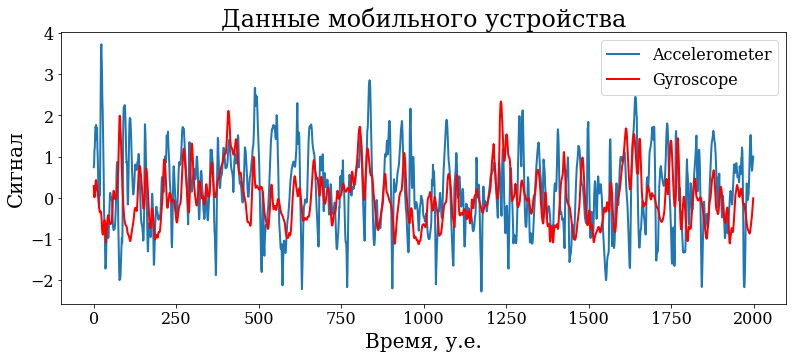

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Данные мобильного устройства")
plt.plot(np.arange(len(x_acc[:2000])), x_acc[:2000], label = 'Accelerometer')
plt.plot(np.arange(len(x_gyr[:2000])), x_gyr[:2000], label = 'Gyroscope', c='r')
plt.xlabel("Время, у.е.")
plt.ylabel("Сигнал")
plt.legend()
# plt.savefig('signal.png')
plt.show()


In [ ]:
X_train = HankelMatrix(x_acc[:3000], 950)
y_train_1 = HankelMatrix(x_gyr[:3000], 950)
# y_train_2 = HankelMatrix(x_gyr[3000:], 1000)

In [ ]:
pls2 = PLSRegression(n_components=30, max_iter=20000).fit(X_train, y_train_1)

In [ ]:
Y_pred_1 = pls2.predict(X_train)
y_pred_1 = HankelMatrix_reverse(Y_pred_1)

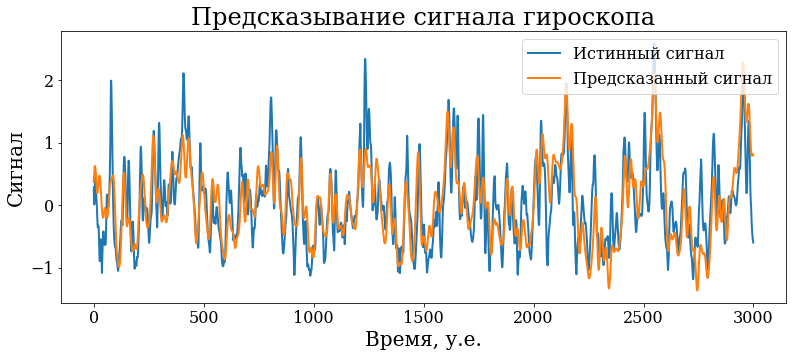

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Предсказывание сигнала гироскопа")
plt.plot(np.arange(len(x_gyr[:3000])), x_gyr[:3000], label = 'Истинный сигнал')
plt.plot(np.arange(len(y_pred_1)), y_pred_1, label = 'Предсказанный сигнал')
plt.xlabel("Время, у.е.")
plt.ylabel("Сигнал")
plt.legend(loc='upper right')
plt.savefig('gyr_pred.png')
plt.show()


### Построение фазовых траекторий

In [ ]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
mean_acc = x_acc.mean()
std_acc = x_acc.std()
x_acc = MakeStationary((x_acc - mean_acc) / std_acc)

mean_gyr = x_gyr.mean()
std_gyr = x_gyr.std()
x_gyr = MakeStationary((x_gyr - mean_gyr) / std_gyr)

In [ ]:
# scaler = StandardScaler()
# scaler.fit(x_acc)
# scaled_acc = scaler.transform(x_acc)

# x_acc = np.array(scaled_acc)

# scaler.fit(x_gyr)
# scaled_gyr = scaler.transform(x_gyr)

# x_gyr = np.array(scaled_gyr)


In [ ]:
# x_acc = np.array(MakeStationary(x_acc))
# x_gyr = np.array(MakeStationary(x_gyr))

In [ ]:
pca = PCA(n_components=3)

H_acc = HankelMatrix(x_acc, L=1100)
x_acc_3d = pca.fit_transform(H_acc)

H_gyr = HankelMatrix(x_gyr, L=1100)
x_gyr_3d = pca.fit_transform(H_gyr)

In [ ]:
def MeanTrajByPeriod(tr, T):
    tr_mean = np.zeros((T + 1, tr.shape[1]))
    for t in range(T):
        tr_mean[t] = np.mean(tr[t::T], axis=0)
    
    tr_mean[-1] = np.copy(tr_mean[0])
    return tr_mean

x_mean = x_gyr[:47][:]

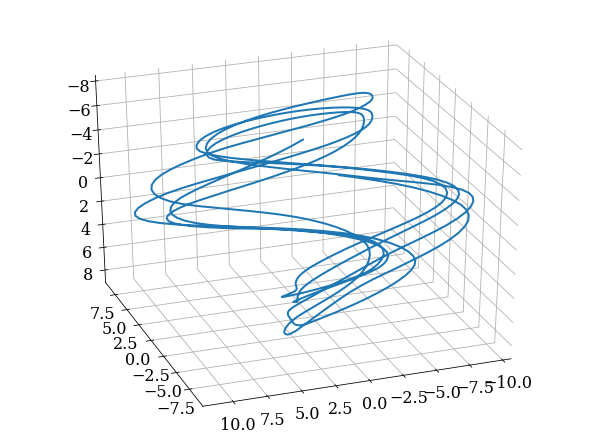

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_acc_3d[:500, 2], x_acc_3d[:500, 1], x_acc_3d[:500, 0])
# ax.plot3D(x_mean[:, 1], x_mean[:, 0], x_mean[:, 2], c='r', linewidth=2)

# ax.set_title("Потребление электроэнергии", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# plt.savefig('pictures/energy_cons_3d_traj_with_mean_no_title.eps', bbox_inches='tight')

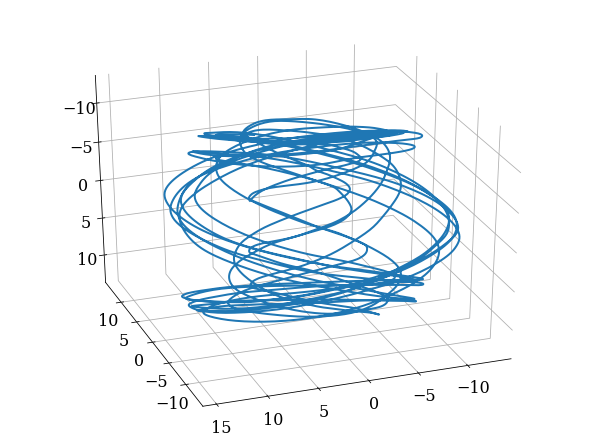

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_gyr_3d[:, 2], x_gyr_3d[:, 1], x_gyr_3d[:, 0])
# ax.plot3D(x_mean[:, 1], x_mean[:, 0], x_mean[:, 2], c='r', linewidth=2)

# ax.set_title("Потребление электроэнергии", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# plt.savefig('pictures/energy_cons_3d_traj_with_mean_no_title.eps', bbox_inches='tight')

In [ ]:
# H_x = HankelMatrix(x, L=1000)
# x_3d = pca.fit_transform(H_x)

In [ ]:
# fig = plt.figure(1, figsize=(8, 6))
# ax = Axes3D(fig, elev=-150, azim=110)

# # ax.set_title("Потребление электроэнергии", size=16)

# ax.set_facecolor((1.0, 1.0, 1.0))
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# # plt.savefig('pictures/energy_cons_3d_traj_with_mean_no_title.eps', bbox_inches='tight')

In [ ]:
mean_pred = y_pred_1.mean()
std_pred = y_pred_1.std()
x_pred = MakeStationary((y_pred_1 - mean_pred) / std_pred)

mean_train = x_gyr[:3000].mean()
std_train = x_gyr[:3000].std()
x_train = MakeStationary((x_gyr[:3000] - mean_train) / std_train)

In [ ]:
H_pred = HankelMatrix(x_pred, L=950)
x_pred_3d = pca.fit_transform(H_pred)

H_train = HankelMatrix(x_train, L=950)
x_train_3d = pca.fit_transform(H_train)

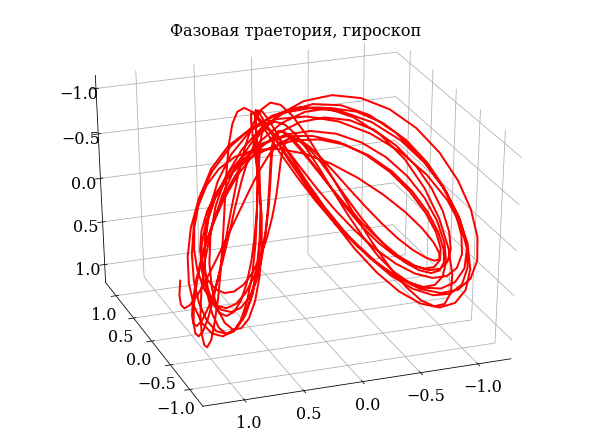

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_train_3d[:500, 2], x_train_3d[:500, 1], x_train_3d[:500, 0], c='r')
# ax.plot3D(x_pred_3d[:500, 2], x_pred_3d[:500, 1], x_pred_3d[:500, 0])

ax.set_title("Фазовая траетория, гироскоп", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# plt.savefig('gyr_tr', bbox_inches='tight')

# CCM

In [ ]:
from sklearn.preprocessing import StandardScaler

def MeanTrajByPeriod(tr, T):
    tr_mean = np.zeros((T + 1, tr.shape[1]))
    for t in range(T):
        tr_mean[t] = np.mean(tr[t::T], axis=0)
    
    tr_mean[-1] = np.copy(tr_mean[0])
    return tr_mean

In [ ]:
x_acc = prepare_time_series('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/Kurdyukova-BS-Thesis/master/code/data/Accelerometer.csv')

x_gyr = prepare_time_series('https://raw.githubusercontent.com/Intelligent-Systems-Phystech/Kurdyukova-BS-Thesis/master/code/data/Gyroscope.csv')

x_acc = x_acc[50:5050]
x_gyr = x_gyr[50:5050]

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.hstack((x_acc[:, np.newaxis], x_gyr[:, np.newaxis])))

x = scaled_data[:, 0]
y = scaled_data[:, 1]

In [ ]:
Hx = HankelMatrix(x, L=900)
Hy = HankelMatrix(y, L=950)

pca = PCA(n_components=3)
x_3d = pca.fit_transform(Hx)
y_3d = pca.fit_transform(Hy)

In [ ]:
x_mean = MeanTrajByPeriod(x_3d[:500], 46)

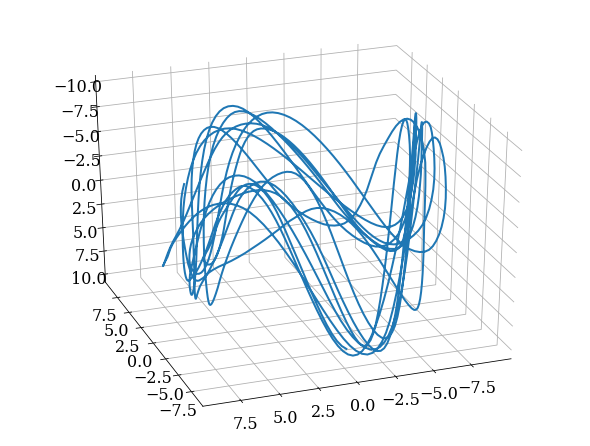

In [ ]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.plot3D(x_3d[:1000, 1], x_3d[:1000, 0], x_3d[:1000, 2])
# ax.plot3D(x_mean[:, 1], x_mean[:, 0], x_mean[:, 2], c='r', linewidth=2)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# ax.set_title("Акселерометр, ходьба", size=16)

# plt.savefig('pictures/accelerometer_3d_wlk_traj_with_mean_no_title.eps', bbox_inches='tight')